In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('./data/Q1_clean.csv')

In [6]:
df.rename(columns={'Neighbourhood ': 'Neighbourhood'}, inplace=True)

In [16]:
# Compute average price and review scores by Neighbourhood
avg_prices = df.groupby('Neighbourhood')['Price'].mean().sort_values(ascending=False)
avg_scores = df.groupby('Neighbourhood')['Review Scores Rating'].mean()

# Identify the most expensive borough
most_expensive_borough = avg_prices.idxmax()
most_expensive_price = avg_prices.max()

print(f"The avg_price is {avg_prices}")

print(f"The most expensive borough on average is {most_expensive_borough} with an average price of ${most_expensive_price:.2f}")

The avg_price is Neighbourhood
Manhattan        183.664286
Staten Island    146.166667
Brooklyn         127.747378
Queens            96.857233
Bronx             75.276498
Name: Price, dtype: float64
The most expensive borough on average is Manhattan with an average price of $183.66


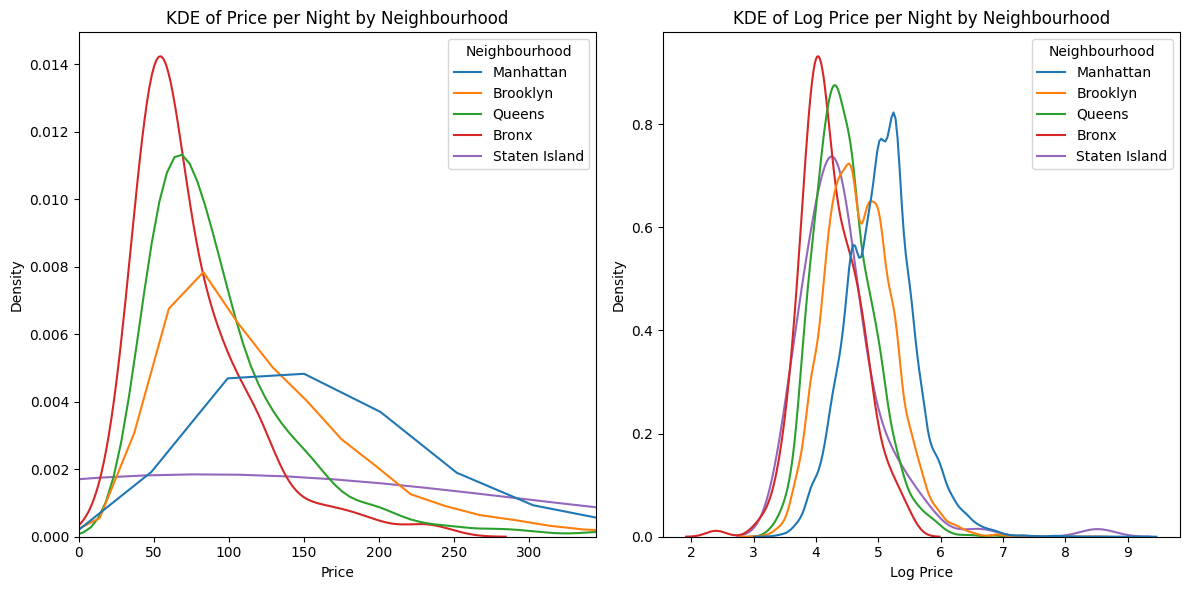

In [9]:
# Kernel Density Plots
plt.figure(figsize=(12, 6))

# KDE for price
plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x='Price', hue='Neighbourhood', common_norm=False)
plt.xlim(0, df['Price'].quantile(0.95))  # Limit x-axis to 95th percentile to reduce extreme outliers
plt.title('KDE of Price per Night by Neighbourhood')

# KDE for log price
plt.subplot(1, 2, 2)
df['Log Price'] = np.log1p(df['Price'])  # log1p to avoid log(0)
sns.kdeplot(data=df, x='Log Price', hue='Neighbourhood', common_norm=False)
plt.title('KDE of Log Price per Night by Neighbourhood')

plt.tight_layout()
plt.show()

In [14]:
#%pip install statsmodels

In [15]:
import statsmodels.api as sm

# One-hot encode Neighbourhood without dropping any category (so no intercept)
df_encoded = pd.get_dummies(df, columns=['Neighbourhood'], drop_first=False)

# Define dependent and independent variables
y = df['Price']
X = df_encoded.filter(like='Neighbourhood')  # Select all one-hot encoded columns

# Fit an OLS regression without an intercept
model = sm.OLS(y, X).fit()

# Display regression results
print(model.summary())

# Compare regression coefficients with average prices
coeff_table = pd.DataFrame({'Regression Coefficients': model.params, 'Mean Prices': avg_prices})
print(coeff_table)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     268.9
Date:                Tue, 04 Mar 2025   Prob (F-statistic):          4.43e-226
Time:                        17:31:55   Log-Likelihood:            -1.4174e+05
No. Observations:               22153   AIC:                         2.835e+05
Df Residuals:                   22148   BIC:                         2.835e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Neighbourhood_Bron

Comparing the regression coefficients from the OLS model with the mean prices computed in part 1, we can see the regression coefficients exactly match the mean prices for each Neighbourhood. Since the regression does not include an intercept, each coefficient represents the mean price per night for that borough. These numbers also exactly match the table from part 1. 


In [18]:
# One-hot encode Neighbourhood, but drop one category (e.g., 'Bronx' as reference)
df_encoded = pd.get_dummies(df, columns=['Neighbourhood'], drop_first=True)

# Define dependent and independent variables
y = df['Price']
X = df_encoded.filter(like='Neighbourhood')  # Select one-hot encoded columns
X = sm.add_constant(X)  # Add intercept

# Fit OLS regression with an intercept
model = sm.OLS(y, X).fit()

# Display regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     268.9
Date:                Tue, 04 Mar 2025   Prob (F-statistic):          4.43e-226
Time:                        17:36:48   Log-Likelihood:            -1.4174e+05
No. Observations:               22153   AIC:                         2.835e+05
Df Residuals:                   22148   BIC:                         2.835e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In part 2, we kept all dummies and excluded the intercept. In this part, we drop one category and include an intercept. The dropped category (Bronx) becomes the baseline.

The intercept is the mean price for the reference category (Bronx).
The other coefficients are the difference in mean price between that borough and the reference (Bronx).

In this regression, the mean price for each borough can be obtained as:

Mean Price for Borough = Intercept + Borough’s Coefficient

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into 80% training and 20% testing
train, test = train_test_split(df, test_size=0.2, random_state=42)

# One-hot encode 'Neighbourhood', dropping one category (e.g., 'Bronx' as reference)
train_encoded = pd.get_dummies(train, columns=['Neighbourhood'], drop_first=True)
test_encoded = pd.get_dummies(test, columns=['Neighbourhood'], drop_first=True)

# Define dependent and independent variables
y_train = train_encoded['Price']
X_train = train_encoded[['Review Scores Rating'] + list(train_encoded.filter(like='Neighbourhood'))]
X_train = sm.add_constant(X_train)  # Add intercept

y_test = test_encoded['Price']
X_test = test_encoded[['Review Scores Rating'] + list(test_encoded.filter(like='Neighbourhood'))]
X_test = sm.add_constant(X_test)

# Fit OLS regression
model = sm.OLS(y_train, X_train).fit()

# Predict on test set
y_pred = model.predict(X_test)

# Compute R² and RMSE
r_squared = model.rsquared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Get coefficient of Review Scores Rating
review_coef = model.params['Review Scores Rating']

# Find the most expensive property type
most_expensive_property = df.groupby('Property Type')['Price'].mean().idxmax()
highest_avg_price = df.groupby('Property Type')['Price'].mean().max()

# Print results
print(f"R² on Test Set: {r_squared:.4f}")
print(f"RMSE on Test Set: {rmse:.2f}")
print(f"Coefficient on Review Scores Rating: {review_coef:.2f}")
print(f"Most Expensive Property Type: {most_expensive_property} (${highest_avg_price:.2f} per night)")

R² on Test Set: 0.0508
RMSE on Test Set: 140.92
Coefficient on Review Scores Rating: 1.21
Most Expensive Property Type: Condominium ($241.23 per night)


In [27]:
# Split data into 80% training and 20% testing
train, test = train_test_split(df, test_size=0.2, random_state=42)

# One-hot encode 'Neighbourhood', dropping one category (e.g., 'Bronx' as reference)
train_encoded = pd.get_dummies(train, columns=['Neighbourhood', 'Property Type'], drop_first=True)
test_encoded = pd.get_dummies(test, columns=['Neighbourhood', 'Property Type'], drop_first=True)

# Define dependent and independent variables
y_train = train_encoded['Price']
X_train = train_encoded[['Review Scores Rating'] + list(train_encoded.filter(like='Neighbourhood'))]
X_train = sm.add_constant(X_train)  # Add intercept

y_test = test_encoded['Price']
X_test = test_encoded[['Review Scores Rating'] + list(test_encoded.filter(like='Neighbourhood'))]
X_test = sm.add_constant(X_test)

# Fit OLS regression
model = sm.OLS(y_train, X_train).fit()

# Predict on test set
y_pred = model.predict(X_test)

# Compute R² and RMSE
r_squared = model.rsquared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Get coefficient of Review Scores Rating
review_coef = model.params['Review Scores Rating']

# Find the most expensive property type
most_expensive_property = df.groupby('Property Type')['Price'].mean().idxmax()
highest_avg_price = df.groupby('Property Type')['Price'].mean().max()

# Print results
print(f"R² on Test Set: {r_squared:.4f}")
print(f"RMSE on Test Set: {rmse:.2f}")
print(f"Coefficient on Review Scores Rating: {review_coef:.2f}")
print(f"Most Expensive Property Type: {most_expensive_property} (${highest_avg_price:.2f} per night)")

R² on Test Set: 0.0508
RMSE on Test Set: 140.92
Coefficient on Review Scores Rating: 1.21
Most Expensive Property Type: Condominium ($241.23 per night)


If the coefficient on Review Scores Rating changed from Part 4 to Part 5, it suggests that Property Type is correlated with both Review Scores Rating and Price. 